In [1]:
import scipy.io as sio
import sklearn as sk
import operator
import json
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from gensim.models import Word2Vec
from scipy.stats import multivariate_normal

In [131]:
work_dir = "/Volumes/Fahimehb/GNN/"

## Read the embeddings:

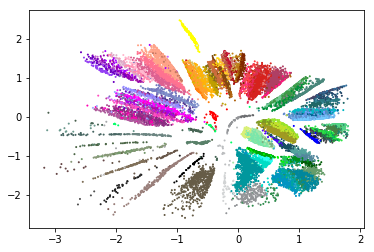

In [2]:
D = sio.loadmat('2d_representation.mat', squeeze_me=True)
plt.scatter(x=D['z'][:, 0], y=D['z'][:, 1], s=1, c=D['color'])

Add cluster id and put the coordinates, cluster_ids and colors into a data frame

In [3]:
D['cluster_id'] = pd.factorize(D['cluster'])[0]

In [4]:
types = np.unique(D['cluster'])
type_ids = np.unique(D['cluster_id'])

In [5]:
df = pd.concat([pd.DataFrame(D['z']), 
                pd.DataFrame(D['cluster']), 
                pd.DataFrame(D['cluster_id']),
                pd.DataFrame(D['color'])], axis=1)
df.columns = ["x", "y", "cluster", "cluster_id", "cluster_color"]

In [6]:
df

x         y                 cluster  cluster_id cluster_color
0      0.369958 -0.594060      L2/3 IT VISp Agmat           0       #7AE6AB
1      0.567149  0.727586             Pvalb Vipr2           1       #FF197F
2     -1.340917  0.715800        Vip Igfbp6 Car10           2       #7779BF
3      0.461240 -0.610380  L2/3 IT ALM Macc1 Lrg1           3       #ADE6A6
4      1.561296  0.399310   L6b VISp Col8a1 Rxfp1           4       #388899
...         ...       ...                     ...         ...           ...
24406  0.297967 -1.302966        L4 IT VISp Rspo1          42       #00979D
24407 -1.697436 -2.092990             Endo Ctla2a          38       #997F7A
24408  0.061318 -1.123602        L4 IT VISp Rspo1          42       #00979D
24409 -0.399719  1.397918        Sst Calb2 Pdlim5          53       #CC6D3D
24410 -1.546328  0.003857       Vip Col15a1 Pde1a          97       #AC3491

[24411 rows x 5 columns]

## Compute moments of each distribution

In [7]:
mu_dict = {}
cov_dict = {}

for c in types:
    X_c = np.array(df[df['cluster'] == c][["x","y"]])
    X_c = X_c.T
    cov = np.cov(X_c) #compute covariance matrix
    mu = np.mean(X_c, axis=1) #compute mean vector
    mu_dict[c] = mu
    cov_dict[c] = cov

In [8]:
mu_dict

{'Astro Aqp4': array([-0.66269356, -1.7065222 ], dtype=float32),
 'Batch Grouping VISp L5 PT Chrna6': array([ 1.1872478, -0.4844831], dtype=float32),
 'Batch Grouping VISp L5 PT Ctxn3': array([ 1.3370998 , -0.42498502], dtype=float32),
 'CR Lhx5': array([-0.73897237, -0.23296414], dtype=float32),
 'Doublet Astro Aqp4 Ex': array([-0.80094016, -1.8874146 ], dtype=float32),
 'Doublet Endo Peri SMC': array([-2.3208919, -1.9480028], dtype=float32),
 'Doublet Endo and Peri_1': array([-1.8839679, -1.7771612], dtype=float32),
 'Doublet SMC and Glutamatergic': array([-1.9981409, -1.3615652], dtype=float32),
 'Doublet VISp L5 NP and L6 CT': array([0.7757471 , 0.45508364], dtype=float32),
 'Endo Ctla2a': array([-1.2817026, -1.5250318], dtype=float32),
 'Endo Cytl1': array([-1.145836 , -1.3055128], dtype=float32),
 'High Intronic VISp L5 Endou': array([ 0.20760484, -1.9936471 ], dtype=float32),
 'L2/3 IT ALM Macc1 Lrg1': array([ 0.501168 , -0.6760681], dtype=float32),
 'L2/3 IT ALM Ptrf': array([ 

For future reference, create a cl_df which has all the cluster properties:

In [9]:
color_dict = {}

for c in types:
    color = np.unique(df[df['cluster'] == c]["cluster_color"])
    color_dict[c] = color[0]

In [10]:
cl_df = pd.DataFrame()
mu_x = []
mu_y = []
color = []

for c in types:
    mu_x.append(mu_dict[c][0])
    mu_y.append(mu_dict[c][1])
    color.append(color_dict[c])

cl_df['cluster'] = types
cl_df['cluster_id'] = type_ids
cl_df['cluster_color'] = color
cl_df['mu_x'] = mu_x
cl_df['mu_y'] = mu_y


In [217]:
cl_df.to_csv("/Volumes/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/GNN/datasets/cl_df.csv")

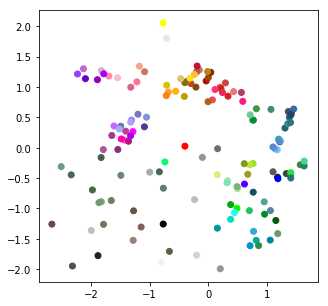

In [193]:
plt.figure(figsize=(5,5))
plt.scatter(x = cl_df['mu_x'], y = cl_df['mu_y'], color = cl_df['cluster_color'])

## Generate random walks based on mu and cov

In [12]:
def Generate_Random_Sample(mu, cov):
    y = np.random.multivariate_normal(mu, cov)
    return y

def Compute_Likelihood(mu, cov, sample):
    LL = multivariate_normal.pdf(x=sample, mean=mu, cov=cov)
    return LL

def Get_Max_LL(LL):
    next_node = max(LL.items(), key=operator.itemgetter(1))[0]
    return next_node

def Get_Next_Node_LL(types, mu_dict, cov_dict, sample):
    sample_LL_scores = {}
    for n in types:
        tmp_mu = mu_dict[n]
        tmp_cov = cov_dict[n]
        LL = Compute_Likelihood(tmp_mu, tmp_cov, sample)
        sample_LL_scores[n] = LL
    next_node = Get_Max_LL(sample_LL_scores)
    return next_node

def Get_Next_Node_KDtree(random_sample, emb, df):
    random_sample_index = emb.shape[0]
    tmp_emb = np.append(emb, [random_sample], axis=0)
    tree = KDTree(tmp_emb)
    nearest_dist, nearest_ind = tree.query(tmp_emb, k=5)
    nn_index_to_random_sample = nearest_ind[random_sample_index][1]
    next_node = df.iloc[nn_index_to_random_sample]['cluster']
    return next_node


In [211]:
n_nodes = len(types)
walk_length = 5
walk_per_node = 200

#random_walks = np.zeros(shape=(n_nodes*walk_per_node, walk_length))
random_walks = []                                                
for i in range (0, n_nodes*walk_per_node):                             
    new = []                  
    for j in range (0, walk_length):    
        new.append("")      
    random_walks.append(new)  

w = 0
for c in types:
    for w_p_n in range(walk_per_node):
        next_node = c
        walk = [next_node]
        w_l = 1
        while w_l < walk_length:
            mu = mu_dict[next_node]
            cov = cov_dict[next_node]
            random_sample =  Generate_Random_Sample(mu, cov)
            #next_node = Get_Next_Node_LL(types, mu_dict, cov_dict, random_sample)
            next_node = Get_Next_Node_KDtree(random_sample, D['z'], df)
            walk.append(next_node)
            w_l = w_l + 1
        random_walks[w] = walk
        w = w + 1


In [212]:
with open(work_dir + '/random_walks.json') as f:
    old_walks = json.load(f)
    
new_walk = old_walks + random_walks

with open(work_dir + '/random_walks.json', "w") as f:
    json.dump(new_walk, f)
    

In [213]:
len(new_walk)

91500

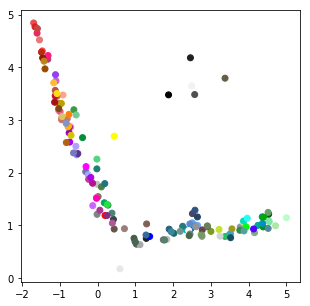

In [215]:
model = Word2Vec(new_walk, min_count = 1, size=2, window=2, sg=1)
plt.figure(figsize=(5,5))
plt.scatter([model.wv[i][0] for i in types], [model.wv[i][1] for i in types], color = color)

In [178]:
model.wv.most_similar("Vip Pygm C1ql1")

[('Microglia Siglech', 0.9999793171882629),
 ('Sst Tac1 Htr1d', 0.9994059205055237),
 ('Vip Lmo1 Fam159b', 0.9986574053764343),
 ('Vip Ptprt Pkp2', 0.9983718395233154),
 ('Sst Esm1', 0.9977049231529236),
 ('PVM Mrc1', 0.9961682558059692),
 ('Sst Crhr2 Efemp1', 0.9960218667984009),
 ('Serpinf1 Aqp5 Vip', 0.9955883026123047),
 ('Low Quality Astro Aqp4', 0.9950751066207886),
 ('Sst Crh 4930553C11Rik ', 0.9939356446266174)]

In [116]:
cl_df

cluster  cluster_id cluster_color      mu_x  \
0                          Astro Aqp4           0       #665C47 -0.662694   
1    Batch Grouping VISp L5 PT Chrna6           1       #231F20  1.187248   
2     Batch Grouping VISp L5 PT Ctxn3           2       #414042  1.337100   
3                             CR Lhx5           3       #00FF66 -0.738972   
4               Doublet Astro Aqp4 Ex           4       #F1F2F2 -0.800940   
..                                ...         ...           ...       ...   
145                     Vip Lmo1 Myl1         145       #9FAAFF -1.518193   
146                    Vip Ptprt Pkp2         146       #FF00FF -1.286420   
147                    Vip Pygm C1ql1         147       #BD3D9A -1.408517   
148                   Vip Rspo1 Itga4         148       #B3128A -1.361663   
149              Vip Rspo4 Rxfp1 Chat         149       #AF00E6 -1.326874   

         mu_y  
0   -1.706522  
1   -0.484483  
2   -0.424985  
3   -0.232964  
4   -1.887415  
..        ...  
145  0.309853  
146  0.267465  
147  0.273607  
148  0.108391  
149  0.196940  

[150 rows x 5 columns]

/Users/fahimehb/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


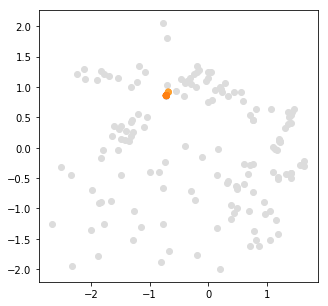

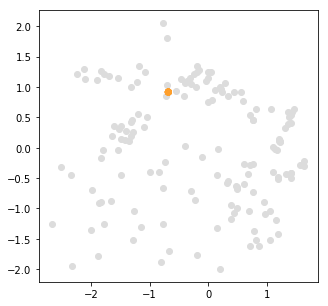

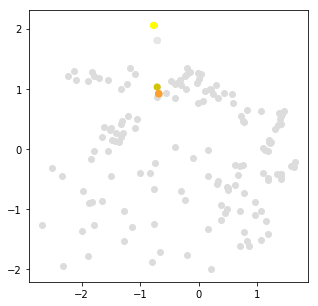

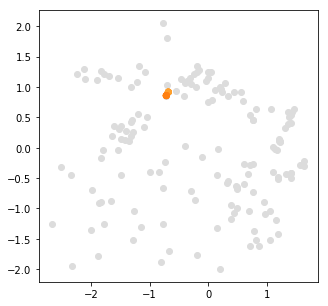

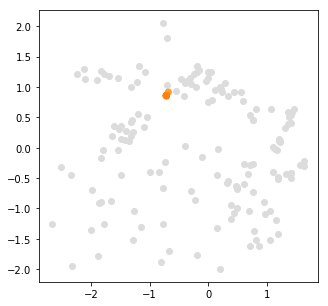

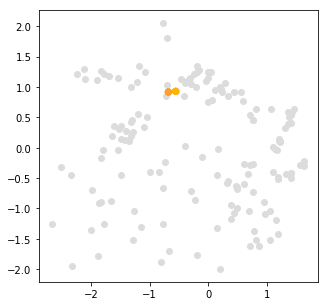

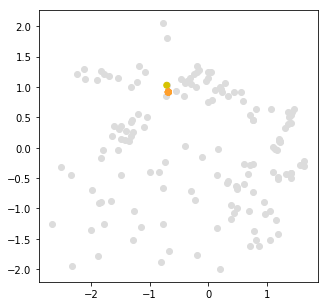

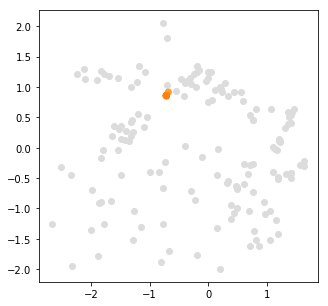

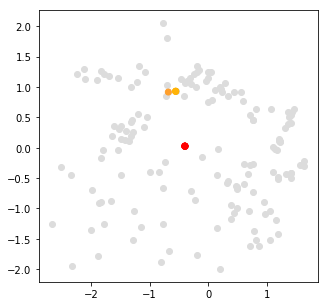

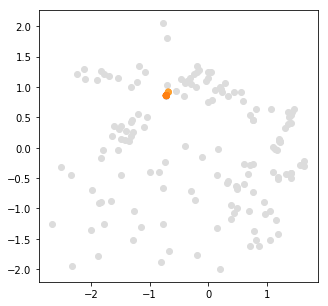

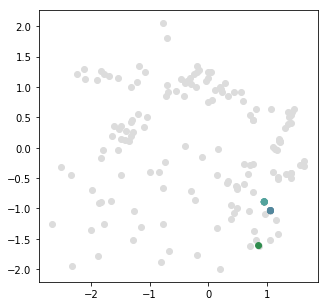

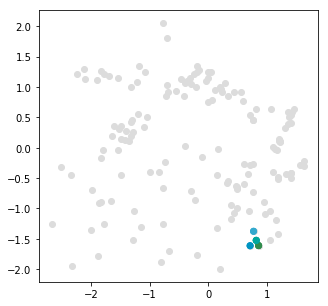

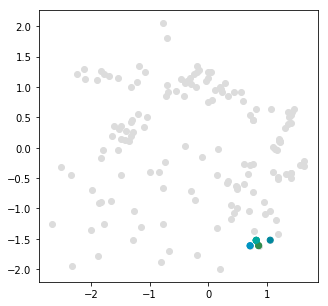

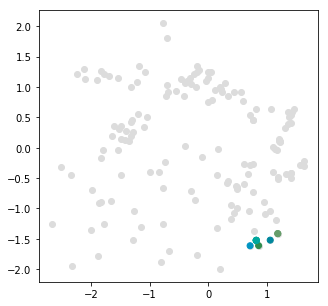

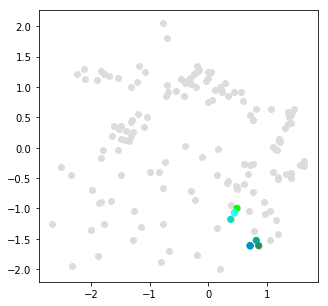

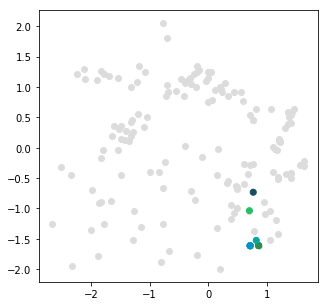

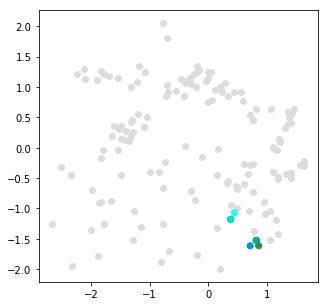

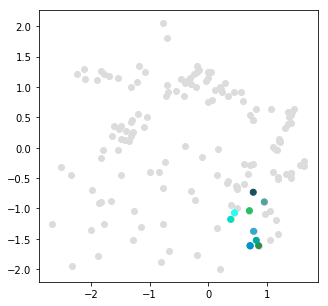

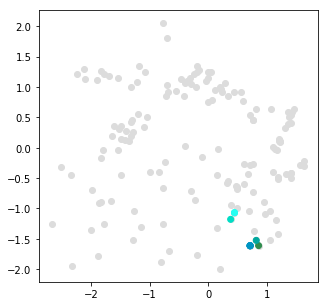

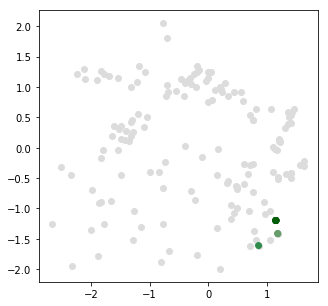

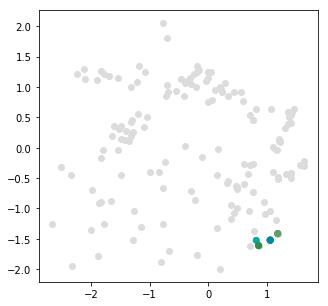

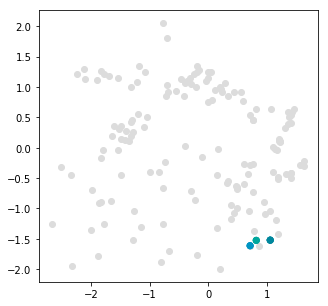

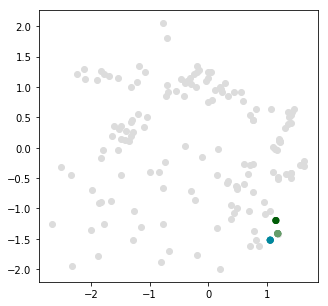

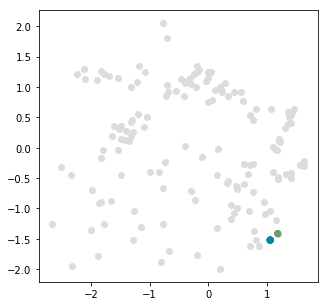

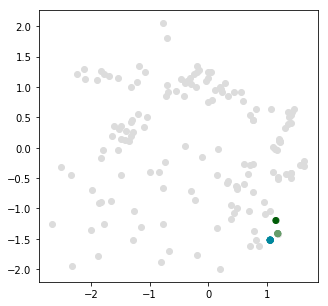

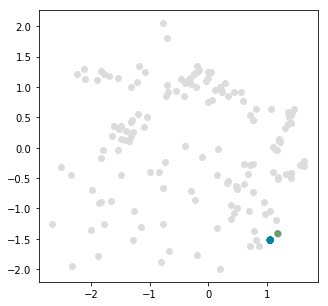

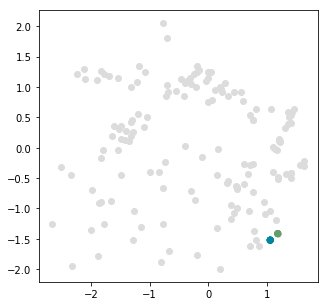

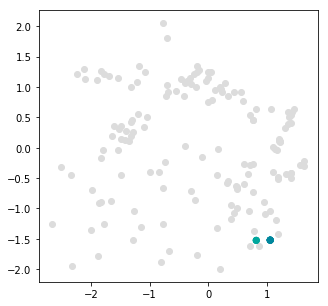

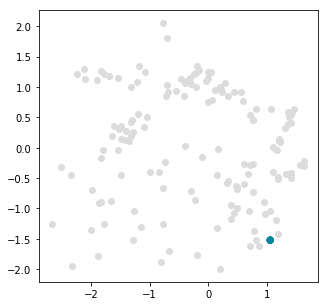

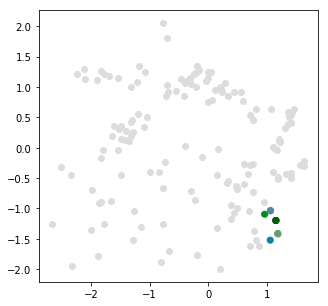

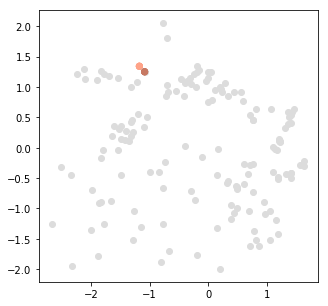

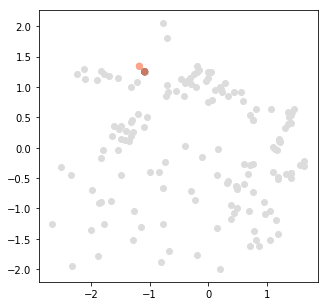

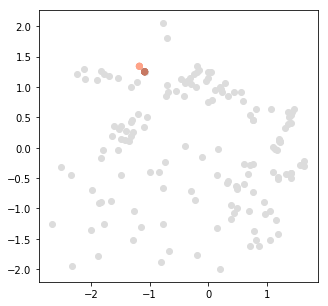

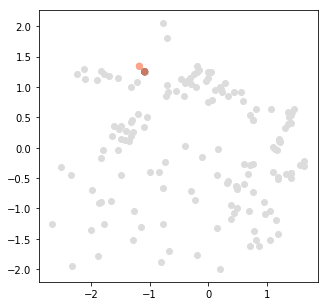

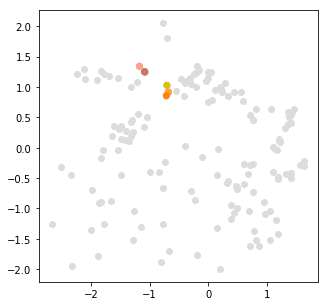

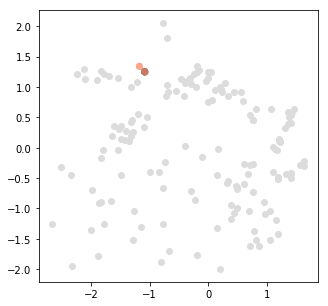

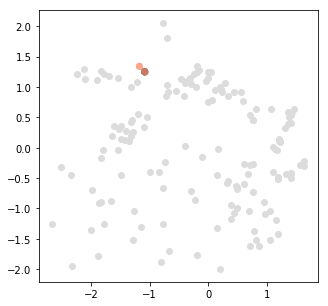

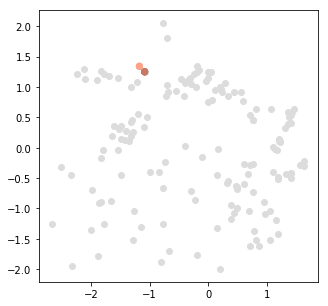

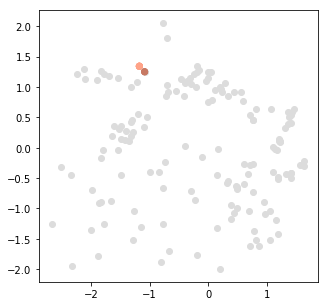

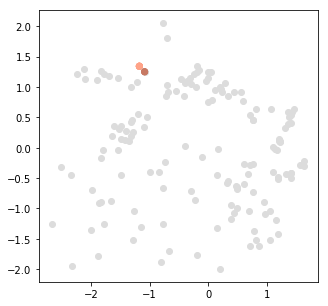

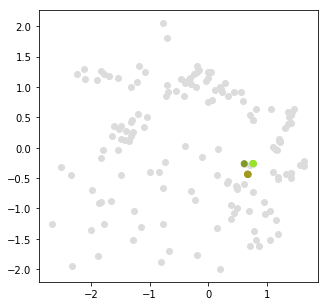

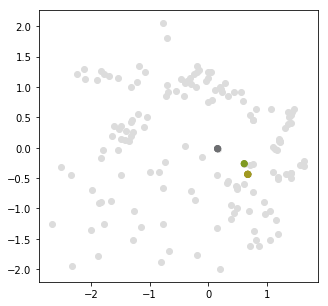

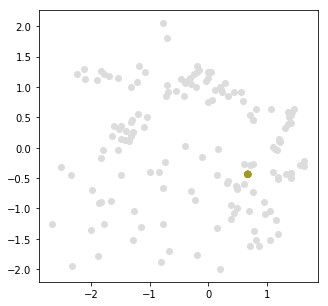

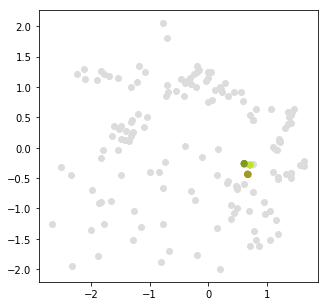

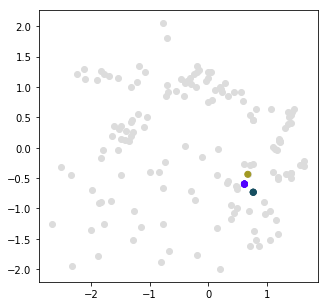

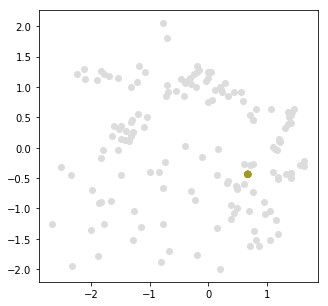

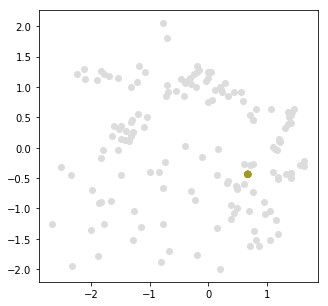

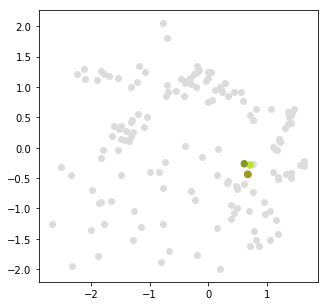

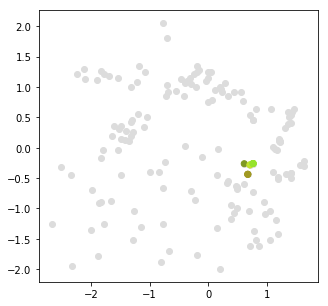

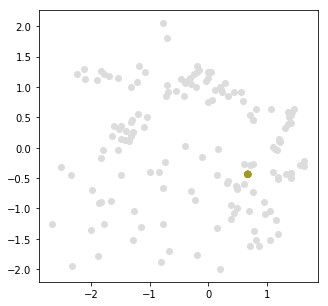

In [17]:
for walk in random_walks[50:100]:
    x = []
    y = []
    color = []
    for w in walk:
        idx = cl_df[cl_df['cluster_id']== w].index.tolist()[0]
        x.append(cl_df.loc[idx]['mu_x'])
        y.append(cl_df.loc[idx]['mu_y'])
        color.append(cl_df.loc[idx]['cluster_color'])
    plt.figure(figsize=(5,5))
    plt.scatter(x = cl_df['mu_x'], y = cl_df['mu_y'], color = "#DCDCDC")
    plt.scatter(x = x, y = y, color = color)

In [167]:
def cosine_distance (model, word, target_list, num) :
    cosine_dict ={}
    word_list = []
    a = model.wv[word]
    for item in types:
        if item != word :
            b = model.wv[item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
            dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True)
            for item in dist_sort:
                word_list.append((item[0], item[1]))
    return word_list[0:num]be